In [6]:
import datetime
import gc
import json
import os
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

def safe_map(x):
    """Map known addresses to owners"""
    try: return known_addresses[x]
    except: return x

# known addresses
# Mix of whaleAPI labels and manual labels
with open("data/known_addresses.json", 'r') as f:
    known_addresses = json.load(f)
    
### Read & Clean ETH blockchain data
# From https://etherscan.io/address/0x5754284f345afc66a98fbb0a0afe71e0f007b949#tokentxns
df = pd.read_csv("usdc.csv", index_col=False)
df['date'] = pd.to_datetime(df.DateTime)
df = df.drop(columns=['DateTime', 'Txhash', 'UnixTimestamp', 'ContractAddress', 'TokenName'])
df.columns = ['from', 'to', 'value', 'token', 'date']
df['chain'] = 'eth'
df = eth[['date', 'value', 'token', 'from', 'to', 'chain']]
df.to = df.to.apply(safe_map)
df['from'] = df['from'].apply(safe_map)

# Fix numeric values
df.value = pd.to_numeric(
    df.value.astype(str)
      .str.replace(",", "")
)
df

,date,value,token,from,to,chain
0,2020-01-01 04:09:48,459717.0,USDC,0xbaf184409be67e26b663aa40a977cfa37a8647fe,usdc,eth
1,2020-01-01 04:13:18,459717.4,USDC,usdc,0xe7ab0dd2a069fa115c0d7878af6fd95ba0f9100a,eth
2,2020-01-01 04:28:22,280000.0,USDC,0xbaf184409be67e26b663aa40a977cfa37a8647fe,usdc,eth
3,2020-01-01 04:28:57,280000.0,USDC,usdc,0xe7ab0dd2a069fa115c0d7878af6fd95ba0f9100a,eth
4,2020-01-01 09:41:02,1000000.0,USDC,0xbaf184409be67e26b663aa40a977cfa37a8647fe,usdc,eth
...,...,...,...,...,...,...
4995,2020-03-19 17:15:04,4492.0,USDC,null,usdc,eth
4996,2020-03-19 17:24:04,2049999.8,USDC,null,usdc,eth
4997,2020-03-19 17:31:36,4492.0,USDC,usdc,0x12620b8ff937a7388e2e13e659133f4034e0eb56,eth
4998,2020-03-19 17:36:10,99999.9,USDC,usdc,0x531ffe5917b855d8dc212ff22db747fd4059555e,eth


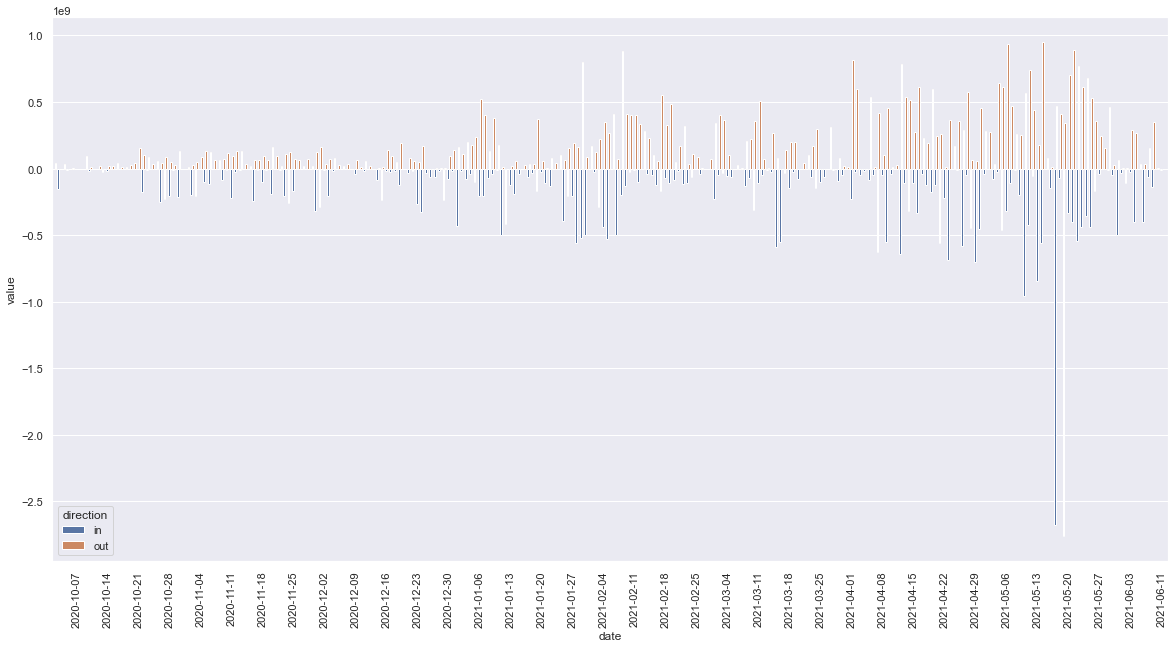

In [22]:
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(
    data=tt.loc[pd.to_datetime(tt.date) > '2020-10-01'],
    x="date", y='value', 
    hue="direction",
    ax=ax
)
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=1, interval=1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
plt.show()

In [14]:
df.loc[(df.direction == 'in') & (df.date >= '2021-05-15')].sort_values(by='value')

,date,value,token,from,to,chain,direction,day
4744,2021-05-31 14:49:22,-1.000000e+09,USDT,bitfinex (mint),tether scrambler eth,eth,in,2021-05-31
4749,2021-05-31 15:12:53,-1.000000e+09,USDT,tether scrambler eth,binance,eth,in,2021-05-31
4746,2021-05-31 15:02:24,-1.000000e+09,USDT,binance,tether scrambler tron,tron,in,2021-05-31
4450,2021-05-17 15:39:48,-1.000000e+09,USDT,bitfinex (mint),tether scrambler eth,eth,in,2021-05-17
4745,2021-05-31 14:52:57,-1.000000e+09,USDT,tether scrambler eth,binance,eth,in,2021-05-31
4748,2021-05-31 15:09:40,-1.000000e+09,USDT,bitfinex (mint),tether scrambler eth,eth,in,2021-05-31
4743,2021-05-31 14:43:18,-1.000000e+09,USDT,binance,tether scrambler tron,tron,in,2021-05-31
4718,2021-05-28 13:04:24,-1.000000e+09,USDT,TBPxhVAsuzoFnKyXtc1o2UySEydPHgATto,tether scrambler tron,tron,in,2021-05-28
4747,2021-05-31 15:06:26,-1.000000e+09,USDT,bitfinex (mint),tether scrambler eth,eth,in,2021-05-31
4661,2021-05-24 17:50:30,-1.000000e+09,USDT,TBPxhVAsuzoFnKyXtc1o2UySEydPHgATto,tether scrambler tron,tron,in,2021-05-24
